# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

#load and preprocessing the dataset
def load_text_dataset(filepath):
    with open(filepath, encoding='utf-8') as f:
        lines = f.readlines()
    labels = [int(line[0]) for line in lines]
    texts = [line[2:].strip() for line in lines]
    return pd.DataFrame({'label': labels, 'text': texts})

#training and testing datasets
train_dataset = load_text_dataset('stsa-train.txt')
test_dataset = load_text_dataset('stsa-test.txt')

#splitting training data
X_train, X_val, y_train, y_val = train_test_split(
    train_dataset['text'], train_dataset['label'], test_size=0.2, random_state=42
)

#vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(test_dataset['text'])

#classifiers
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

#10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=kfold, scoring='accuracy')
    print(f"{name} - Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"{name} - Validation Accuracy: {acc:.4f}, Recall: {rec:.4f}, Precision: {prec:.4f}, F1 Score: {f1:.4f}")
    y_test_pred = clf.predict(X_test_tfidf)
    test_acc = accuracy_score(test_dataset['label'], y_test_pred)
    print(f"{name} - Test Accuracy: {test_acc:.4f}")

def train_word2vec(texts):
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
    return model

w2v_model = train_word2vec(X_train)
X_train_w2v = np.array([np.mean([w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                                 or [np.zeros(100)], axis=0) for text in X_train])
X_val_w2v = np.array([np.mean([w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                               or [np.zeros(100)], axis=0) for text in X_val])
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                                or [np.zeros(100)], axis=0) for text in test_dataset['text']])

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_w2v, y_train)
y_pred_w2v = rf_clf.predict(X_val_w2v)
print("Word2Vec + Random Forest - Validation Accuracy:", accuracy_score(y_val, y_pred_w2v))

#BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

def encode_texts_bert(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        list(texts),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return encodings['input_ids'], encodings['attention_mask']

X_train_ids, X_train_masks = encode_texts_bert(X_train, bert_tokenizer)
X_val_ids, X_val_masks = encode_texts_bert(X_val, bert_tokenizer)
X_test_ids, X_test_masks = encode_texts_bert(test_dataset['text'], bert_tokenizer)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

bert_model.fit(
    [X_train_ids, X_train_masks], y_train,
    validation_data=([X_val_ids, X_val_masks], y_val),
    batch_size=32,
    epochs=3
)
bert_test_loss, bert_test_acc = bert_model.evaluate([X_test_ids, X_test_masks], test_dataset['label'])
print(f"BERT - Test Accuracy: {bert_test_acc:.4f}")
bert_val_predictions = bert_model.predict([X_val_ids, X_val_masks])
bert_val_pred_classes = tf.argmax(bert_val_predictions.logits, axis=1).numpy()
bert_val_report = classification_report(y_val, bert_val_pred_classes, target_names=["Negative", "Positive"])
print(f"BERT - Validation Metrics:\n{bert_val_report}")
bert_test_predictions = bert_model.predict([X_test_ids, X_test_masks])
bert_test_pred_classes = tf.argmax(bert_test_predictions.logits, axis=1).numpy()
bert_test_report = classification_report(test_dataset['label'], bert_test_pred_classes, target_names=["Negative", "Positive"])
print(f"BERT - Test Metrics:\n{bert_test_report}")

Naive Bayes - Cross-Validation Accuracy: 0.7704
Naive Bayes - Validation Accuracy: 0.7854, Recall: 0.8345, Precision: 0.7687, F1 Score: 0.8003
Naive Bayes - Test Accuracy: 0.7814
SVM - Cross-Validation Accuracy: 0.7693
SVM - Validation Accuracy: 0.7782, Recall: 0.8233, Precision: 0.7643, F1 Score: 0.7927
SVM - Test Accuracy: 0.7738
K-Nearest Neighbors - Cross-Validation Accuracy: 0.5090
K-Nearest Neighbors - Validation Accuracy: 0.5282, Recall: 0.3759, Precision: 0.5630, F1 Score: 0.4508
K-Nearest Neighbors - Test Accuracy: 0.5167
Decision Tree - Cross-Validation Accuracy: 0.6286
Decision Tree - Validation Accuracy: 0.6243, Recall: 0.6438, Precision: 0.6331, F1 Score: 0.6384
Decision Tree - Test Accuracy: 0.6222
Random Forest - Cross-Validation Accuracy: 0.7000
Random Forest - Validation Accuracy: 0.7088, Recall: 0.7616, Precision: 0.6997, F1 Score: 0.7293
Random Forest - Test Accuracy: 0.7084
XGBoost - Cross-Validation Accuracy: 0.6949
XGBoost - Validation Accuracy: 0.7247, Recall: 0.

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
173/173 [==============================] - 197s 950ms/step - loss: 0.3728 - accuracy: 0.8351 - val_loss: 0.2152 - val_accuracy: 0.9220
Epoch 2/3
173/173 [==============================] - 160s 926ms/step - loss: 0.1549 - accuracy: 0.9427 - val_loss: 0.2339 - val_accuracy: 0.9140
Epoch 3/3
57/57 [==============================] - 17s 292ms/step - loss: 0.2495 - accuracy: 0.9198
BERT - Test Accuracy: 0.9198
44/44 [==============================] - 16s 295ms/step
BERT - Validation Metrics:
              precision    recall  f1-score   support

    Negative       0.93      0.90      0.91       671
    Positive       0.91      0.93      0.92       713

    accuracy                           0.92      1384
   macro avg       0.92      0.92      0.92      1384
weighted avg       0.92      0.92      0.92      1384

57/57 [==============================] - 17s 299ms/step
BERT - Test Metrics:
              precision    recall  f1-score   support

    Negative       0.94      0.90      

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TF-IDF K-Means Silhouette Score: 0.037047402497351126
Key terms in each cluster:
Cluster 0: iphone new phone like brand
Cluster 1: love phone great works thank
Cluster 2: thanks expected great phone came
Cluster 3: good phone product far works
Cluster 4: phone good work great screen
Cluster 5: excellent product condition thank recommend
Cluster 6: great works phone product price
Cluster 7: perfect condition phone works great


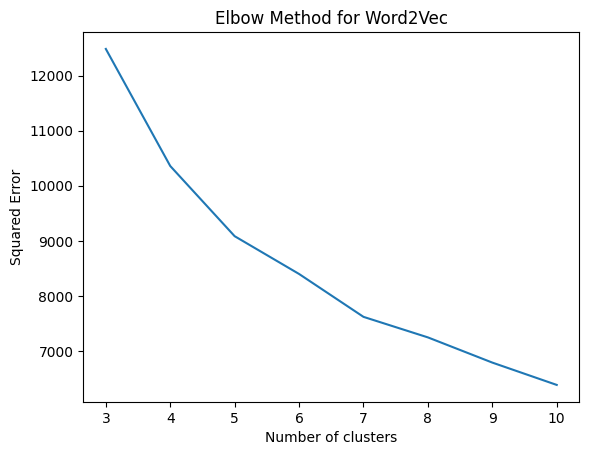

Optimal Cluster Count: 10
Word2Vec K-Means Silhouette Score: 0.21595004945055143
DBSCAN Silhouette Score: 0.4269454802610259


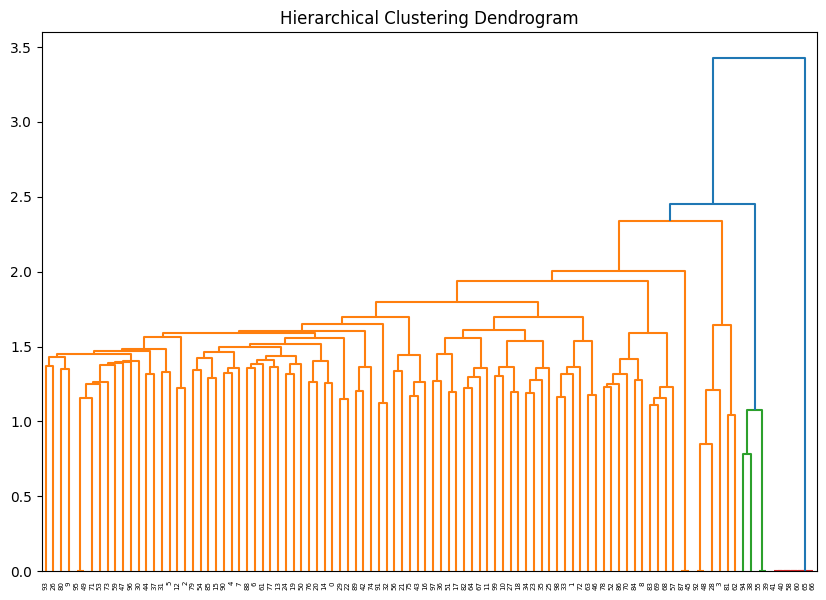

Hierarchical Clustering Silhouette Score: 0.1117045647581076
BERT K-Means Silhouette Score: 0.0771806


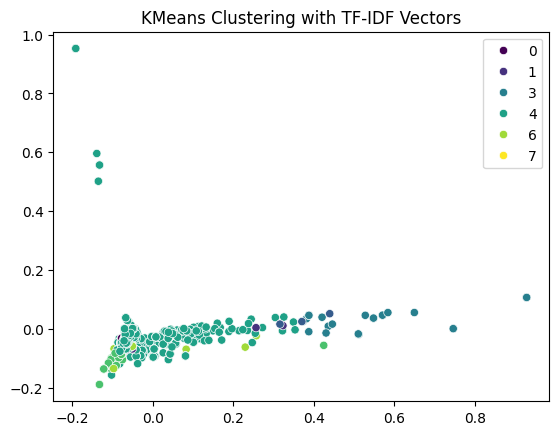

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import re
import nltk
from nltk.corpus import stopwords

# Downloading NLTK data
nltk.download('stopwords')
nltk.download('punkt')
data = pd.read_csv("Amazon_Unlocked_Mobile.csv", low_memory=False)
data = data.dropna(subset=['Reviews'])
reviews = data['Reviews'].values[:10000]

def preprocess_text(text):
    text = text.lower() #converting to smaller case
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

reviews = [preprocess_text(review) for review in reviews] #Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(reviews)

kmeans_tfidf = KMeans(n_clusters=8, random_state=99)
kmeans_tfidf.fit(X_tfidf)
labels_tfidf = kmeans_tfidf.labels_
# Silhouette Score
print("TF-IDF K-Means Silhouette Score:", silhouette_score(X_tfidf, labels_tfidf))
print("Key terms in each cluster:")
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]
for i in range(8):
    print(f"Cluster {i}: {' '.join([terms[ind] for ind in order_centroids[i, :5]])}")
sentences = [review.split() for review in reviews]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# getting sentence vect
def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

X_word2vec = np.array([get_sentence_vector(review, word2vec_model) for review in reviews])
if np.isnan(X_word2vec).any():
    X_word2vec = np.nan_to_num(X_word2vec)

squared_errors = []
num_clusters = range(3, 11)
for cluster in num_clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(X_word2vec)
    squared_errors.append(kmeans.inertia_)

optimal_clusters = num_clusters[np.argmin(squared_errors)]
plt.plot(num_clusters, squared_errors)
plt.title("Elbow Method for Word2Vec")
plt.xlabel("Number of clusters")
plt.ylabel("Squared Error")
plt.show()
print("Optimal Cluster Count:", optimal_clusters)
kmeans_w2v = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_w2v_labels = kmeans_w2v.fit_predict(X_word2vec)
print("Word2Vec K-Means Silhouette Score:", silhouette_score(X_word2vec, kmeans_w2v_labels))
# DBSCAN Clustering
dbscan = DBSCAN(eps=1.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_word2vec)
if len(set(dbscan_labels)) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(X_word2vec, dbscan_labels))
else:
    print("DBSCAN Silhouette Score: N/A (only one cluster)")
# Hierarchical Clustering
linked = linkage(X_tfidf.toarray()[:100], 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

hierarchical_labels = fcluster(linked, t=5, criterion='maxclust')
print("Hierarchical Clustering Silhouette Score:", silhouette_score(X_tfidf[:100].toarray(), hierarchical_labels))
#BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
X_bert = np.array([get_bert_embedding(review) for review in reviews[:100]])
kmeans_bert = KMeans(n_clusters=5, random_state=42)
kmeans_bert_labels = kmeans_bert.fit_predict(X_bert)
print("BERT K-Means Silhouette Score:", silhouette_score(X_bert, kmeans_bert_labels))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray()[:1000])
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_tfidf[:1000], palette='viridis')
plt.title('KMeans Clustering with TF-IDF Vectors')
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**
The results of the applied text clustering algorithms K-means, DBSCAN, Hierarchical Clustering, Word2Vec, and BERT for the Amazon reviews can present the following distinctions. Despite this, DBSCAN and Hierarchical Clustering were in general capable of providing of higher quality results or detecting of outliers and at the same time were more computationally resource-consuming than K-means. Word2Vec and BERT offered more semantically related and contextually helpful information regarding the documents but were computationally expensive for feature extraction. K-means was the most scalable and efficient method, however the results depends on the choice of the initial centroids, the number of clusters. The choice of approach to the problem depends on the constraints set at the stage of the work, including the need to obtain an explicit form of dependencies, when it is necessary to filter out outliers and noise, and the available computational capabilities. It may be likely that using these algorithms together, or a technique of choosing the best of them in each iteration, might be the most accurate and efficient text clustering method.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

I must say that the text clustering exercises have been a good learning point for me due to the extra knowledge
gained from the results that showed the effectiveness of different clustering algorithms when used in the
context of text data.
'''